In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ml").getOrCreate()

In [2]:
#spark.stop()

In [3]:
df = spark.read.csv("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv",header=True)

df.createOrReplaceTempView("dfTable")

In [4]:
df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|

In [5]:
from pyspark.sql.functions import min, max

# Examine the data

In [6]:
df2=spark.sql("SELECT *  FROM dfTable")

In [7]:
#Find the total number of tickets
df2.count()

10803028

In [8]:
df2.show(4)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|

### Find the total number of tickets for the year.

In [9]:
df2=spark.sql("SELECT *  FROM dfTable where year(`Issue Date`)=2017")

In [10]:
df2.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|       MITSU|                14|             14|         1120A|
|    5096917368| FZD8593|                NY|2017-06-13|             7|             SUBN|       ME/BE|                 0|              0|         0852P|
|    1407740258| 2513JMG|                NY|2017-01-11|            78|             DELV|       FRUEH|               106|            106|         0015A|
|    1413656420|T672371C|                NY|2017-02-04|            40|             TAXI|

In [11]:
#Find the total number of tickets for the year.
df2.count()

5431918

In [12]:
#Find out the number of unique states from where the cars that got parking tickets came. 
#(Hint: Use the column 'Registration State'.)

In [13]:
print( "Unique States: ",df2.select('Registration State').distinct().count() )

df2.groupBy('Registration State').count().sort('count',ascending=False).show()

Unique States:  65
+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|4273951|
|                NJ| 475825|
|                PA| 140286|
|                CT|  70403|
|                FL|  69468|
|                IN|  45525|
|                MA|  38941|
|                VA|  34367|
|                MD|  30213|
|                NC|  27152|
|                TX|  18827|
|                IL|  18666|
|                GA|  17537|
|                99|  16055|
|                AZ|  12379|
|                OH|  12281|
|                CA|  12153|
|                ME|  10806|
|                SC|  10395|
|                MN|  10083|
+------------------+-------+
only showing top 20 rows



In [14]:
df2 = df2.replace(["99"],["NY"], 'Registration State')

In [15]:
print( "Unique States: ",df2.select('Registration State').distinct().count() )

df2.groupBy('Registration State').count().sort('count',ascending=False).show()

Unique States:  64
+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|4290006|
|                NJ| 475825|
|                PA| 140286|
|                CT|  70403|
|                FL|  69468|
|                IN|  45525|
|                MA|  38941|
|                VA|  34367|
|                MD|  30213|
|                NC|  27152|
|                TX|  18827|
|                IL|  18666|
|                GA|  17537|
|                AZ|  12379|
|                OH|  12281|
|                CA|  12153|
|                ME|  10806|
|                SC|  10395|
|                MN|  10083|
|                OK|   9088|
+------------------+-------+
only showing top 20 rows



In [16]:
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit, month

In [17]:
#Create a new fieled to identify local people vs non-locals
df2 = df2.withColumn('Local',lit(1))
df2 =  df2.withColumn("Local",when((df2["Registration State"] != "NY"), 0).otherwise(1))

# Aggregation tasks

In [18]:
#How often does each violation code occur? Display the frequency of the top five violation codes.

In [19]:
df2.printSchema()

root
 |-- Summons Number: string (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: string (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: string (nullable = true)
 |-- Issuer Precinct: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Local: integer (nullable = false)



## Identify Null Values in Any Field of the dataset

In [20]:
def null_value_count(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(df[k].isNull()).count()
        temp = k,nullRows
        null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_count_list = null_value_count(df2)

print("Null Value Columns")
null_columns_count_list

Null Value Columns


[('Summons Number', 0),
 ('Plate ID', 0),
 ('Registration State', 0),
 ('Issue Date', 0),
 ('Violation Code', 0),
 ('Vehicle Body Type', 0),
 ('Vehicle Make', 0),
 ('Violation Precinct', 0),
 ('Issuer Precinct', 0),
 ('Violation Time', 0),
 ('Local', 0)]

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

### Vehicle Analysis

In [22]:
#Total Number of Unique Vehicles
df3=df2.select('Plate ID').groupBy('Plate ID').count().sort('count',ascending=False)
df3.count()

1974356

In [23]:
#Vehicles with BlankPlate : 5261

df_plate =df3.toPandas()[:50]
df_plate

,Plate ID,count
0,BLANKPLATE,5261
1,96089MA,529
2,96087MA,528
3,94905JA,527
4,14828MJ,526
5,85848MD,512
6,30954JX,510
7,2121796,507
8,16242TC,496
9,2194153,495


In [24]:
def bar_plot(df, X):
    plt.figure(figsize=(20,5))
    ax1=sns.barplot(x=X, y='count', data=df)

    plt.title(X)
    plt.ylabel("Count") 
    plt.xlabel(X) 

    sns.set_style("white")

    # Rotate the labels on x-axis
    for item in ax1.get_xticklabels():
        item.set_rotation(90)

    plt.show()

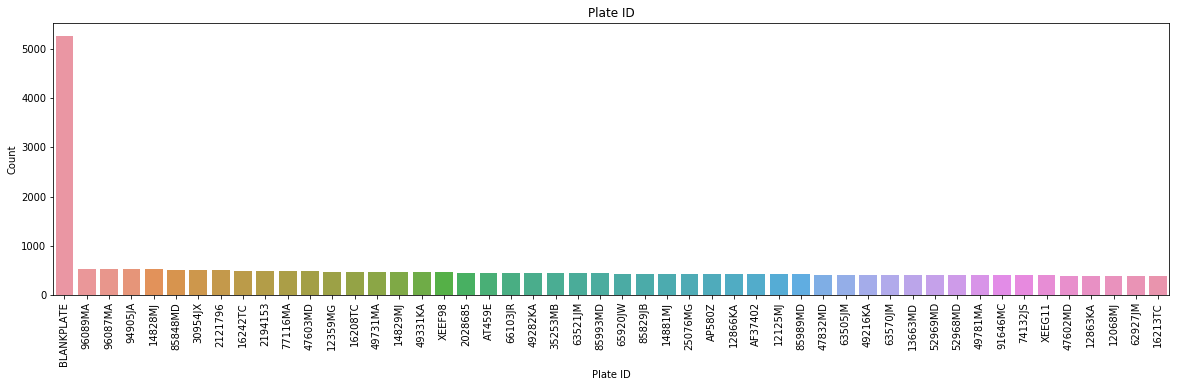

In [25]:
bar_plot(df_plate,"Plate ID")

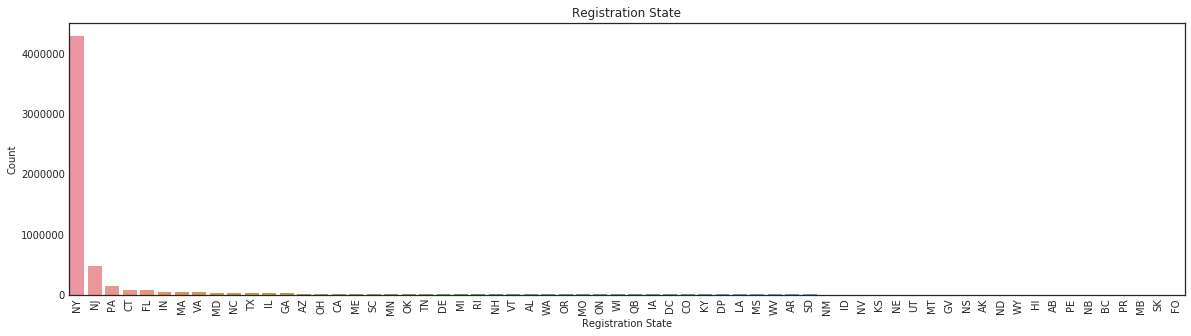

In [26]:
df3=df2.select('Registration State').groupBy('Registration State').count().sort('count',ascending=False)
df_state =df3.toPandas()
bar_plot(df_state,"Registration State")

In [27]:
df_state[:30]

,Registration State,count
0,NY,4290006
1,NJ,475825
2,PA,140286
3,CT,70403
4,FL,69468
5,IN,45525
6,MA,38941
7,VA,34367
8,MD,30213
9,NC,27152


In [28]:
from pyspark.sql.functions import date_trunc
from pyspark.sql.functions import dayofmonth, month, dayofweek

In [29]:
df3=df2.select('Summons Number').groupBy('Summons Number').count().sort('count',ascending=False)
df3.show(10)

+--------------+-----+
|Summons Number|count|
+--------------+-----+
|    1408877752|    1|
|    8552404114|    1|
|    8510508367|    1|
|    8504604640|    1|
|    8420016240|    1|
|    8506250031|    1|
|    1408831820|    1|
|    8563502657|    1|
|    7693543661|    1|
|    7824137582|    1|
+--------------+-----+
only showing top 10 rows



## Montly Ticket Issue
### Almost no data is available from Jul to Dec Period
### From the availalbe data most Tickets were issued in May followed by Mar.

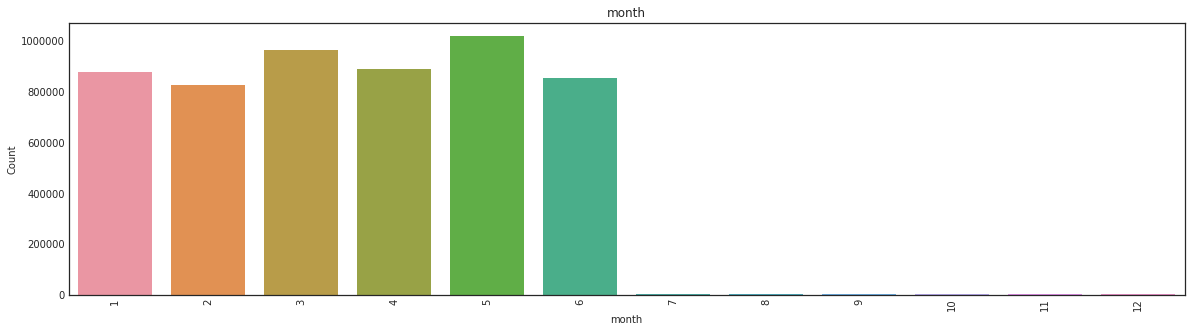

In [30]:
df_month = df2.select(month(df2["Issue Date"]).alias('month')).groupBy('month').count().sort('count',ascending=False).toPandas()
bar_plot(df_month,"month")

In [31]:
df_month[:4]

,month,count
0,5,1020244
1,3,964737
2,4,888402
3,1,877365


## Day of Week Ticket Issue
### On Monday there are least # of tickets issued followed by Sat. Friday and Wed are most ticket issued.

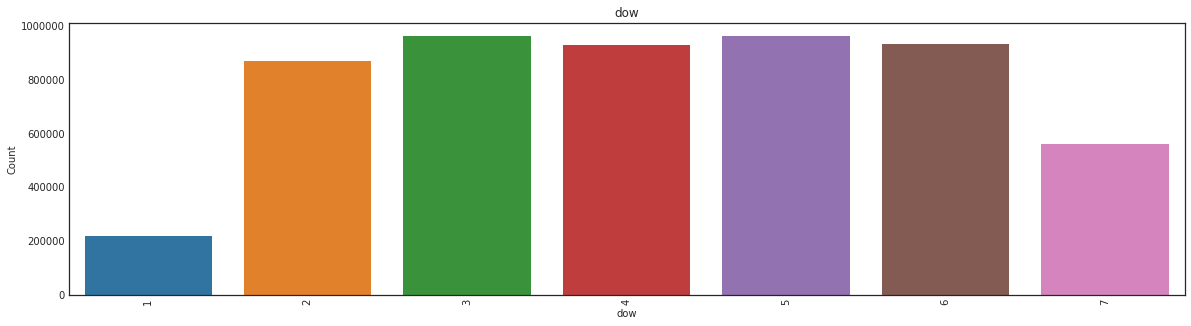

In [32]:
df_dow   = df2.select(dayofweek(df2["Issue Date"]).alias('dow')).groupBy('dow').count().sort('count',ascending=False).toPandas()
bar_plot(df_dow,"dow")

In [33]:
df_dow[:7]

,dow,count
0,5,962045
1,3,961584
2,6,932620
3,4,927707
4,2,869368
5,7,560356
6,1,218238


### Is there any trend of Local (New Yorker) vs Non-Local on Any Weekday
#### Most of Tickets are for Local people. No significant difference on any day.

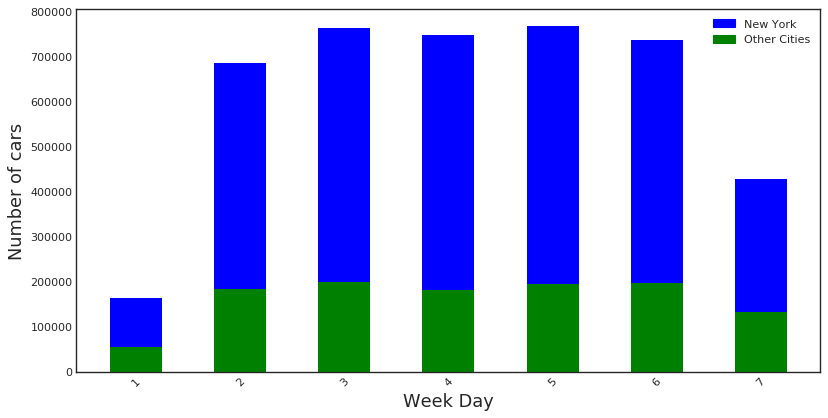

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df_dow   = df2.select(dayofweek(df2["Issue Date"]).alias('dow'), df2["Local"]).groupBy('dow',"Local").count().sort('count',ascending=False).toPandas()

df_dow_local= df_dow[ df_dow.Local==1]
df_dow_nlocal=df_dow[ df_dow.Local==0]

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k') #size of the plot

#labels=#['Mon','Tue','Wed','Thu','Fri','Sat','Sun'] 
plt.bar(df_dow_local['dow'] , df_dow_local['count'], color = 'b', width = 0.5) # plotting the graph
plt.bar(df_dow_nlocal['dow'], df_dow_nlocal['count'], color = 'g', width = 0.5)
plt.xticks(df_dow_local['dow'],  rotation=45) #providing xticks to the graph

blue_patch=mpatches.Patch(color='b',label='New York') 
green_patch=mpatches.Patch(color='g',label='Other Cities')
plt.legend(handles=[blue_patch,green_patch]) #providing the labels
plt.xlabel('Week Day',fontsize=16)
plt.ylabel('Number of cars',fontsize=16)
plt.show()

## Day of Month
#### Most number of tickets are issued on 3 of every month, followed by 27, 20 & 6

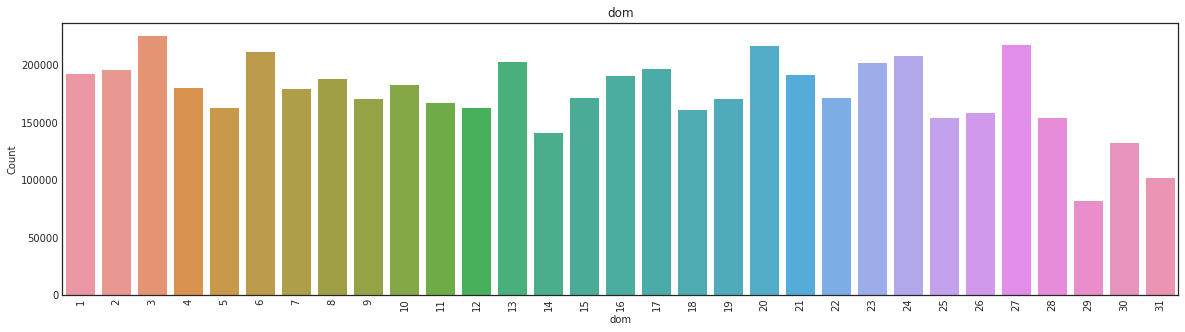

In [35]:
df_dom   = df2.select(dayofmonth(df2["Issue Date"]).alias('dom')).groupBy('dom').count().sort('count',ascending=False).toPandas()
bar_plot(df_dom,"dom")

In [36]:
df_dom[:4]

,dom,count
0,3,225398
1,27,216891
2,20,216504
3,6,211419


### 1  How often does each violation code occur? Display the frequency of the top five violation codes.
#### Most of the violoation happend for code 21, followed by 36.

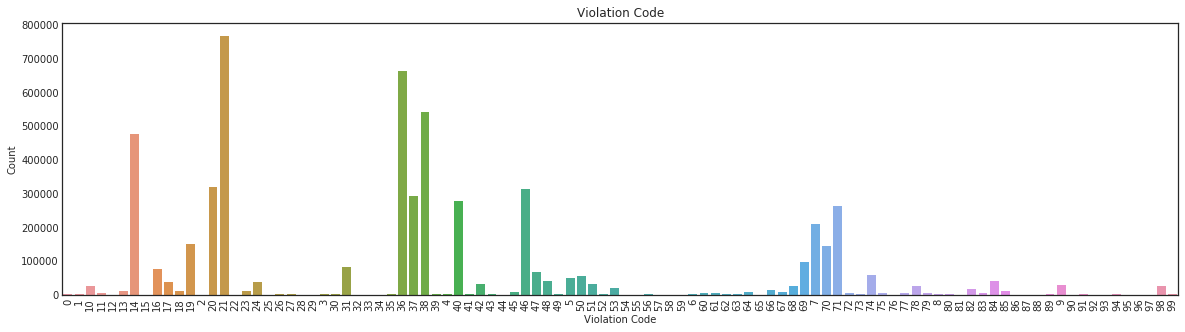

In [37]:
df3=df2.select('Violation Code').groupBy('Violation Code').count().sort('count',ascending=False)
df_violation =df3.toPandas()
bar_plot(df_violation,"Violation Code")

In [38]:
print(len(df_violation))
df_violation[:5]

100


,Violation Code,count
0,21,768087
1,36,662765
2,38,542079
3,14,476664
4,20,319646


In [39]:
df_violation.to_csv("violation.csv")

### 2 How often does each 'vehicle body type' get a parking ticket?  (Hint: Find the top 5 for both.)
### Most of the vechicle getting tickets have SUBN body type, followed by 4 DSD type

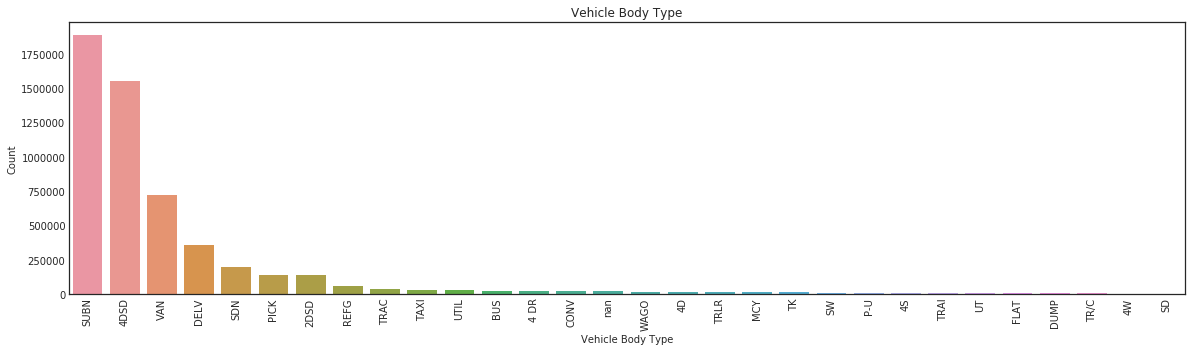

In [40]:
df3=df2.select('Vehicle Body Type').groupBy('Vehicle Body Type').count().sort('count',ascending=False)
df_vb =df3.toPandas()
bar_plot(df_vb[:30],"Vehicle Body Type")

In [41]:
print( len(df_vb))
df_vb[:5]

1165


,Vehicle Body Type,count
0,SUBN,1883954
1,4DSD,1547312
2,VAN,724029
3,DELV,358984
4,SDN,194197


### 2 How often does each 'vehicle make' get a parking ticket?  (Hint: Find the top 5)
### Ford Vechicle get ticket most frequently followed by Toyota and Honda

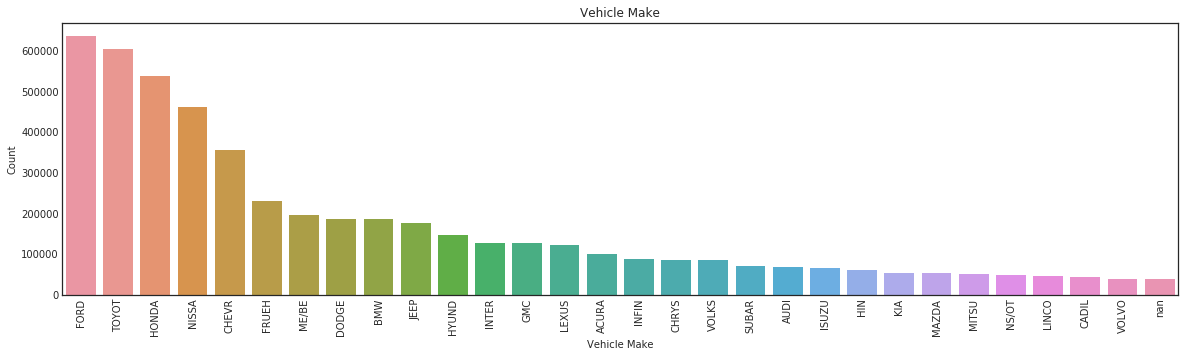

In [42]:
df3=df2.select('Vehicle Make').groupBy('Vehicle Make').count().sort('count',ascending=False)
df_vm =df3.toPandas()
bar_plot(df_vm[:30],"Vehicle Make")

In [43]:
print (len(df_vm))
df_vm[:5]

3179


,Vehicle Make,count
0,FORD,636844
1,TOYOT,605291
2,HONDA,538884
3,NISSA,462017
4,CHEVR,356032


### 3. A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following:

### 3.1 'Violation Precinct' (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city?

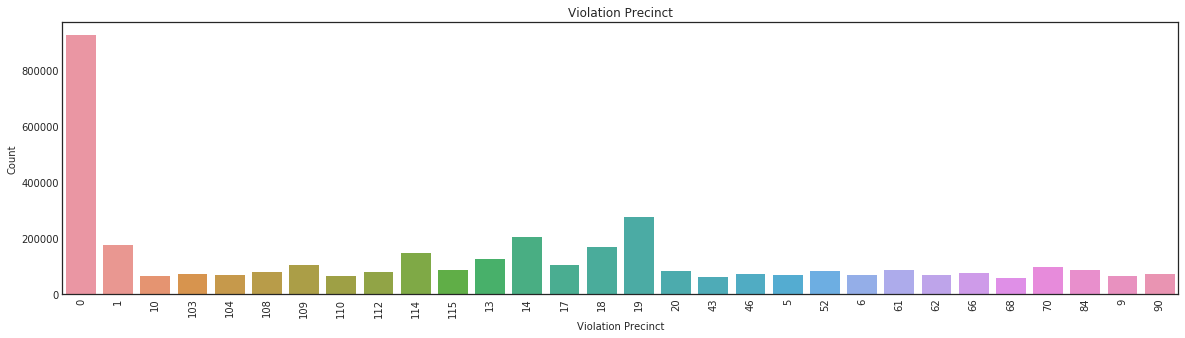

In [44]:
df3=df2.select('Violation Precinct').groupBy('Violation Precinct').count().sort('count',ascending=False)
df_vp =df3.toPandas()
bar_plot(df_vp[:30],"Violation Precinct")

#### Here, you would have noticed that the dataframe has the 'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts. (Hint: Print the top six entries after sorting.)

In [45]:
print(len(df_vp))
df_vp.loc[:6]

171


,Violation Precinct,count
0,0,925596
1,19,274445
2,14,203553
3,1,174702
4,18,169131
5,114,147444
6,13,125113


In [46]:
print(df_vp['count'].sum())
(100*df_vp['count'].cumsum()/df_vp['count'].sum()).loc[:30]

5431918


0     17.039948
1     22.092399
2     25.839749
3     29.055961
4     32.169613
5     34.884013
6     37.187307
7     39.102063
8     41.002957
9     42.780451
10    44.396657
11    45.997767
12    47.567839
13    49.075373
14    50.573205
15    52.057653
16    53.526655
17    54.938605
18    56.295032
19    57.631982
20    58.943986
21    60.199473
22    61.444724
23    62.687029
24    63.923148
25    65.144669
26    66.345957
27    67.511384
28    68.617678
29    69.690209
30    70.758358
Name: count, dtype: float64

#### Most of violations are happening in zone 0. 
#### 52% of violotation are happening in 29 areas (i.e. 16% of areas are source 52% of violation)

### 3.2 'Issuer Precinct' (This is the precinct that issued the ticket.)

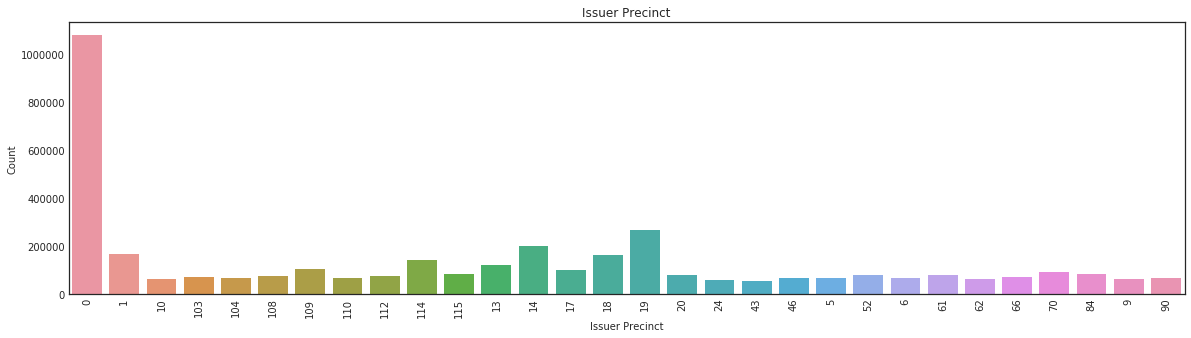

In [47]:
df3=df2.select('Issuer Precinct').groupBy('Issuer Precinct').count().sort('count',ascending=False)
df_ip =df3.toPandas()
bar_plot(df_ip[:30],"Issuer Precinct")

#### Here, you would have noticed that the dataframe has the 'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts. (Hint: Print the top six entries after sorting.)

In [48]:
print(len(df_ip))
df_ip[0:6]

511


,Issuer Precinct,count
0,0,1078406
1,19,266961
2,14,200495
3,1,168740
4,18,162994
5,114,144054


In [49]:
print(df_ip['count'].sum())
(100*df_ip['count'].cumsum()/df_ip['count'].sum()).loc[:30]

5431918


0     19.853135
1     24.767808
2     28.458861
3     31.565314
4     34.565986
5     37.217977
6     39.472982
7     41.408007
8     43.260778
9     44.959957
10    46.533674
11    48.063354
12    49.563874
13    51.044346
14    52.505800
15    53.928999
16    55.340324
17    56.668289
18    57.947856
19    59.217518
20    60.463615
21    61.685762
22    62.906749
23    64.124293
24    65.336977
25    66.535007
26    67.704520
27    68.838226
28    69.892918
29    70.934760
30    71.972938
Name: count, dtype: float64

#### Most of Tickets are issued by zone 0 (this is error code)
#### 52% of violotation are happening in 29 areas (i.e. 5.7% of issuer prcinct are source 52% of violation) [Here I have ignored error code 0]

### 4 Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts?

In [50]:
#Top 3 Precincts where violations are most
df_ip[:4]

,Issuer Precinct,count
0,0,1078406
1,19,266961
2,14,200495
3,1,168740


In [51]:
df3=spark.sql("select `Issuer Precinct`, `Violation Code` from dfTable where `Issuer Precinct` in (19,14,1)")

df4=df3.select("Issuer Precinct", "Violation Code").groupBy("Issuer Precinct","Violation Code").count().sort('count', ascending=False)
df_issuer_violation =df4.toPandas()


In [52]:
#In Princinct 19 Most Violoation is against Violation Code 46 
#46 => 	Standing or parking on the roadway side of a vehicle stopped, standing or parked at the curb; in other words 
# also known as "double parking". However, a person may stand a Commercial Vehicle alongside a vehicle parked at the 
# curb at such locations and during such hours that stopping, standing and parking is allowed when quickly making pickups, 
# deliveries or service calls. This is allowed if there is no parking space or marked loading zone on either 
# side of the street within 100 feet. "Double parking" any type of vehicle is not allowed in Midtown Manhattan 
# (the area from 14th Street to 60th Street, between First Avenue and Eighth Avenue inclusive). Midtown double 
# parking is not allowed between 7:00am – 7:00pm daily except Sundays. (Read Code 47)

df_issuer_violation.loc[df_issuer_violation['Issuer Precinct']=='19'].head(3)

,Issuer Precinct,Violation Code,count
0,19,46,86390
3,19,37,72437
4,19,38,72344


In [53]:
#In Princinct 14 Most Violoation is against Violation Code 14 
#14=> (Standing or parking where standing is not allowed by sign, street marking or; traffic control device.)
df_issuer_violation.loc[df_issuer_violation['Issuer Precinct']=='14'].head(3)

,Issuer Precinct,Violation Code,count
1,14,14,73837
5,14,69,58026
8,14,31,39857


In [54]:
#In Princinct 1 Most Violoation is against Violation Code 14 
df_issuer_violation.loc[df_issuer_violation['Issuer Precinct']=='1'].head(3)

,Issuer Precinct,Violation Code,count
2,1,14,73522
9,1,16,38937
12,1,20,27841


In [56]:
#df_issuer_violation[ df_issuer_violation['Issuer Precinct']].sort_values(["Season","count"],ascending=False).head(3)

### 5 Find out the properties of parking violations across different times of the day

#### 5.1 Find a way to deal with missing values, if any.
##### (Hint: Check for the null values using 'isNull' under the SQL. Also, to remove the null values, check the 'drop na' command in the API documentation.)

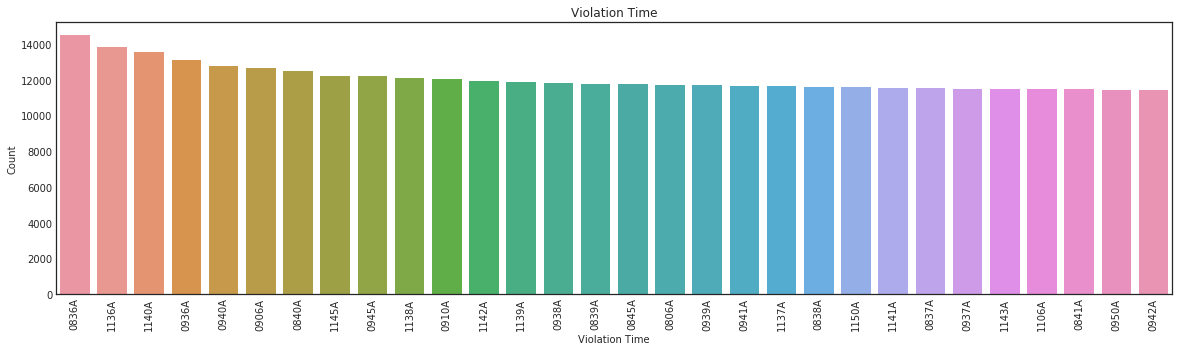

In [57]:
df3=df2.select('Violation Time').groupBy('Violation Time').count().sort('count',ascending=False)
df_vt =df3.toPandas()

bar_plot(df_vt[:30],"Violation Time")

In [58]:
#remove those time records which has <= 10 counts. Those are wrong time entries
df_vt = df_vt[ df_vt['count']>10 ]

#Remoe those records which has time values null. There are 16 Records like that.
df_vt = df_vt[ df_vt['Violation Time']!='nan']

#### 5.2 The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can use to divide into groups.

In [59]:
def getDate(x):
    
    if x[-1::]=="A" and int(x[:4:])>=1200 and int(x[:4:])<=1259 : #Mid night 1200 and ownards to till 12:59 remove hours.
        return "00:" + x[2:4]    
    
    if x[-1::]=="P" and int(x[:4:])>=0 and int(x[:4:])<=59 : #if 12PM and onwards till 1259 pm first 2 digits 12 not 00
        return "12:" + x[2:4]
    
    if x[-1::]=="P" and int(x[:4:])>=100 and int(x[:4:])<=1159 : #if 1PM and onwards till 1159 pm add 12 hours
        return str(int(x[:2:])+12) + ":" + x[2:4]
    else:
        return x[:2] +":"+x[2:4]


In [60]:
df_vt['Time'] = df_vt['Violation Time'].apply(getDate)
df_vt['Hours'] = df_vt['Time'].str[:2].astype(int)


In [61]:
df_vt.head()

,Violation Time,count,Time,Hours
0,0836A,14492,08:36,8
1,1136A,13808,11:36,11
2,1140A,13546,11:40,11
3,0936A,13128,09:36,9
4,0940A,12763,09:40,9


In [62]:
df_vt1 = df_vt.groupby("Hours").sum().reset_index()

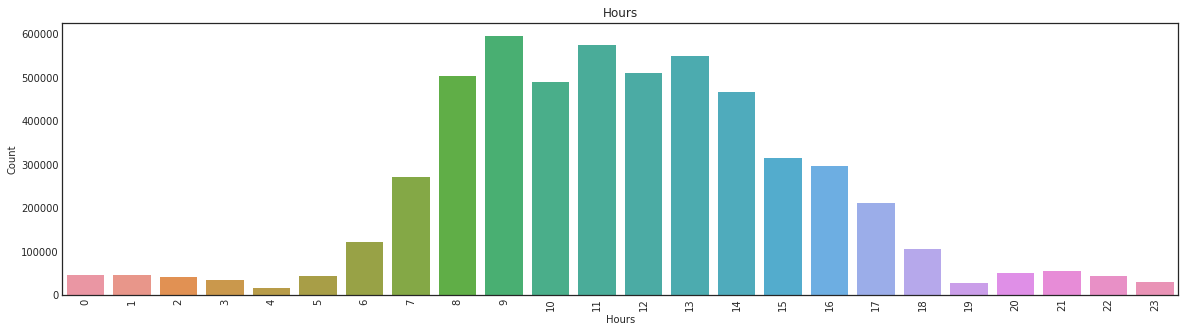

In [63]:
bar_plot(df_vt1,"Hours")

#### 5.3 Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.
##### (Hint: Use the CASE-WHEN in SQL view to segregate into bins. To find the most commonly occurring violations, you can use an approach similar to the one mentioned in the hint for question 4.)

In [64]:
import pandas as pd
df_vt1['TimeBin'] = pd.cut(df_vt1.Hours,[-1,5,7,13,16,18,23],labels=[1,2,3,4,5,6])
df_vt1

,Hours,count,TimeBin
0,0,45698,1
1,1,46068,1
2,2,40312,1
3,3,32453,1
4,4,14545,1
5,5,43154,1
6,6,121550,2
7,7,270626,2
8,8,503843,3
9,9,595625,3


### 6.a  First, divide the year into a certain number of seasons (Hint: Use Issue Date to segregate into seasons.) 

In [65]:
#Spring begins with the Vernal Equinox, Thursday, March 19, 2017, 11:50 p.m.
#Summer begins with the Summer Solstice, Saturday, June 20, 2017, 5:44 p.m.
#Autumn begins with the Autumnal Equinox, Tuesday, September 22, 2017, 9:31 a.m.
#Winter begins with the Winter Solstice, Monday, December 21, 2018, 5:02 a.m.

#To keep it simple
#Winter (1) =1,2,3
#Spring (2) =4,5,6
#Summer (3) =7,8,9
#Autumn (4) =9,10,11

In [67]:
#Create a new fieled Month
df2 = df2.withColumn('Month', month(df2["Issue Date"]))
#Create a new field Season
df2 = df2.withColumn('Season',lit(1))
df2 = df2.withColumn("Season",when((df2["Month"] >= 1) & (df2["Month"]<=3),  1).otherwise(df2["Season"]))
df2 = df2.withColumn("Season",when((df2["Month"] >= 4) & (df2["Month"]<=6),  2).otherwise(df2["Season"]))
df2 = df2.withColumn("Season",when((df2["Month"] >= 7) & (df2["Month"]<=9),  3).otherwise(df2["Season"]))
df2 = df2.withColumn("Season",when((df2["Month"] >=10) & (df2["Month"]<=12), 4).otherwise(df2["Season"]))

In [68]:
df3=df2.select('Season').groupBy('Season').count().sort('count',ascending=False)
df_season =df3.toPandas()
df_season

,Season,count
0,2,2760833
1,1,2669069
2,3,1046
3,4,970


In [69]:
df3=df2.select('Season','Violation Code').groupBy('Season','Violation Code').count().sort('count',ascending=False)
df_season_violation =df3.toPandas()

### 6.b  Find the three most common violations for each of these seasons.

In [70]:
df_season_violation[ df_season_violation.Season==1].sort_values(["Season","count"],ascending=False).head(3)

,Season,Violation Code,count
1,1,21,373874
2,1,36,348240
4,1,38,287000


In [71]:
df_season_violation[ df_season_violation.Season==2].sort_values(["Season","count"],ascending=False).head(3)

,Season,Violation Code,count
0,2,21,393885
3,2,36,314525
5,2,38,255064


In [72]:
df_season_violation[ df_season_violation.Season==3].sort_values(["Season","count"],ascending=False).head(3)

,Season,Violation Code,count
128,3,21,228
131,3,46,219
140,3,40,109


In [73]:
df_season_violation[ df_season_violation.Season==4].sort_values(["Season","count"],ascending=False).head(3)

,Season,Violation Code,count
130,4,46,219
138,4,40,121
143,4,21,100


### 7 The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes: 

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
#Top Three violation code
df_fine =df_violation[:3]
df_fine

,Violation Code,count
0,21,768087
1,36,662765
2,38,542079


In [76]:
#Average Fine for these codes is (from the given link)
#21 => $55
#36 => $50
#38 => $50

In [77]:
df_fine.loc[:,'Fine_Rate'] = [55,50,50]
df_fine["Total_Fine"] = df_fine["count"] * df_fine["Fine_Rate"]

In [78]:
df_fine

,Violation Code,count,Fine_Rate,Total_Fine
0,21,768087,55,42244785
1,36,662765,50,33138250
2,38,542079,50,27103950


In [79]:
print("Total Fine Collected from top 3 violations")
print('{:,}'.format(  df_fine.Total_Fine.sum() ) )

Total Fine Collected from top 3 violations
102,486,985


In [80]:
df_fine['count'].sum() / df_violation['count'].sum()

0.3632107480267559

#### Top 3 fine code applied to 36% (almost 1/3) of the tickets